In [2]:
import numpy as np
import mne
import scipy.io
from eeg_preprocessing_functions import (
    apply_temporal_filtering, correct_artifacts_ica,
    apply_sliding_window, extract_dwt_features
)

# --- Configuration Constants ---
SFREQ = 256.0
N_CHANNELS = 64
LINE_FREQ = 50
LOW_FREQ = 0.5
HIGH_FREQ = 100
T_MIN = -0.5
T_MAX = 3.5
WINDOW_DURATION = 1.0
STRIDE_DURATION = 0.25

def load_mat_data(mat_file_path):
    """
    Loads EEG data from .mat file with the specific structure you described.
    """
    print(f"--- Loading .mat file: {mat_file_path} ---")
    
    # Load the .mat file
    mat_data = scipy.io.loadmat(mat_file_path)
    
    # Extract epo_train data - CORRECTED based on your feedback
    epo_train = mat_data['epo_train']
    
    eeg_data = epo_train['x'][0][0]  # Shape: (795, 64, 300)
    labels_onehot = epo_train['y'][0][0]  # Shape: (5, 300) - One-hot encoded
    
    # Extract channel names from mnt
    mnt_data = mat_data['mnt']
    channel_names = []
    
    for i in range(64):
        channel_array = mnt_data['clab'][0][0][0][i]
        channel_name = str(channel_array[0])
        channel_names.append(channel_name)
    
    print(f"   -> EEG Data Shape: {eeg_data.shape}")
    print(f"   -> Labels Shape (one-hot): {labels_onehot.shape}")
    print(f"   -> Channel Names: {channel_names[:5]}...")
    
    # Convert one-hot encoded labels to single labels
    # Find which position has the '1' in each column
    labels_1d = np.argmax(labels_onehot, axis=0)  # Shape: (300,)
    unique_words = np.unique(labels_1d)
    
    print(f"   -> Unique labels: {len(unique_words)}")
    print(f"   -> Label values: {unique_words}")
    print(f"   -> Number of trials per class: {np.bincount(labels_1d)}")
    print(f"   -> One-hot encoding example (first 5 trials):")
    print(f"      Labels one-hot: {labels_onehot[:, :5]}")
    print(f"      Converted labels: {labels_1d[:5]}")
    
    return eeg_data, labels_1d, channel_names, unique_words

def create_mne_info_from_mat(sfreq, channel_names):
    """
    Creates MNE Info structure using actual channel names from the .mat file.
    """
    print("--- Creating MNE Info Structure ---")
    
    ch_types = ['eeg'] * len(channel_names)
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=ch_types)
    
    try:
        montage = mne.channels.make_standard_montage('standard_1020')
        info.set_montage(montage)
        print("   -> Standard 10-20 montage applied.")
    except Exception as e:
        print(f"   -> Could not set standard montage: {e}")
    
    return info

def prepare_continuous_data(eeg_data_3d, labels_1d, info):
    """
    Converts epoched data back to continuous format for MNE processing.
    """
    print("--- Preparing Continuous Data for MNE Processing ---")
    
    n_epochs, n_channels, n_times = eeg_data_3d.shape
    
    # Transpose to (n_channels, n_times, n_epochs) then reshape
    continuous_data = eeg_data_3d.transpose(1, 0, 2)  # Now (64, 795, 300)
    continuous_data = continuous_data.reshape(n_channels, -1)  # (64, 795*300)
    
    print(f"   -> Original epochs shape: {eeg_data_3d.shape}")
    print(f"   -> Continuous data shape: {continuous_data.shape}")
    
    # Scale to volts (assuming your data is in microvolts)
    continuous_data_scaled = continuous_data / 1e6
    
    # Create MNE Raw object
    raw = mne.io.RawArray(continuous_data_scaled, info, verbose=False)
    
    # Create events array - place markers at the start of each epoch
    events = []
    for i, label in enumerate(labels_1d):
        start_sample = i * n_times
        events.append([start_sample, 0, int(label)])  # Use actual label as event ID
    
    events = np.array(events)
    
    print(f"   -> Number of events: {len(events)}")
    print(f"   -> Last event sample: {events[-1, 0]}")
    print(f"   -> Total samples in raw: {raw.n_times}")
    print(f"   -> Unique event IDs in events: {np.unique(events[:, 2])}")
    
    return raw, events, labels_1d

def create_marker_array_from_events(events, n_times):
    """
    Creates a marker array from events for the segmentation function.
    """
    marker_array = np.zeros(n_times)
    for event in events:
        marker_array[event[0]] = event[2]
    return marker_array

# Custom segment_and_epoch function with proper event handling
def custom_segment_and_epoch(raw_clean, marker_array, unique_words):
    """Segments the continuous cleaned data into fixed-length trials (epochs)."""
    print("\n--- Segmentation and Epoching ---")

    # 1. Create MNE Events Array
    events = []
    event_indices = np.where(marker_array != 0)[0]

    for idx in event_indices:
        event_id = int(marker_array[idx])
        events.append([idx, 0, event_id])

    events = np.array(events)
    
    print(f"   -> Found {len(events)} events in marker array")
    print(f"   -> Unique event IDs in marker: {np.unique(events[:, 2])}")

    # 2. Create event_id dictionary using ACTUAL event IDs found in the data
    actual_event_ids = np.unique(events[:, 2])
    event_id_dict = {}
    
    for event_id in actual_event_ids:
        event_id_dict[str(event_id)] = event_id
    
    print(f"   -> Event ID mapping: {event_id_dict}")

    # 3. Create epochs
    epochs = mne.Epochs(
        raw_clean,
        events=events,
        event_id=event_id_dict,
        tmin=T_MIN,
        tmax=T_MAX,
        baseline=(-0.5, 0),
        preload=True,
        verbose=False,
        on_missing='warn'
    )

    # Final data shape: (N_events, N_channels, N_time_points)
    eeg_data_3d = epochs.get_data()
    
    # Labels are the same as the original event IDs
    eeg_labels_1d = epochs.events[:, 2]

    print(f"   -> Created {len(epochs)} epochs")
    print(f"   -> Epochs data shape: {eeg_data_3d.shape}")
    print(f"   -> Labels shape: {eeg_labels_1d.shape}")
    print(f"   -> Unique labels in epochs: {np.unique(eeg_labels_1d)}")

    return eeg_data_3d, eeg_labels_1d, event_id_dict

# Direct epoched processing with proper label handling
def process_epoched_data_directly(eeg_data_3d, labels_1d, channel_names):
    """
    Alternative approach that processes the already epoched data directly
    without converting to continuous format.
    """
    print("\n--- Processing Epoched Data Directly ---")
    
    # Transpose to MNE format: (n_epochs, n_channels, n_times)
    eeg_data_mne = eeg_data_3d.transpose(2, 1, 0)  # (300, 64, 795)
    
    print(f"   -> Transposed data shape: {eeg_data_mne.shape}")
    print(f"   -> Labels shape: {labels_1d.shape}")
    
    # Create info structure
    info = create_mne_info_from_mat(SFREQ, channel_names)
    
    # Create an EpochsArray object directly
    epochs = mne.EpochsArray(eeg_data_mne, info, verbose=False)
    
    # Apply filtering directly to epochs
    print("--- Applying Temporal Filtering to Epochs ---")
    epochs_filtered = epochs.copy()
    epochs_filtered.filter(l_freq=LOW_FREQ, h_freq=HIGH_FREQ, fir_design='firwin', verbose=False)
    epochs_filtered.notch_filter(freqs=LINE_FREQ, verbose=False)
    
    print("   -> Bandpass and Notch filters applied to epochs.")
    print("   -> Skipping ICA for direct epoched processing.")
    
    return epochs_filtered.get_data(), labels_1d

if __name__ == '__main__':
    
    # 1. Load your actual .mat data
    mat_file_path = "BCI2020 EEG Signal for Words/Training set/Data_Sample01.mat"
    
    try:
        eeg_data_3d, labels_1d, channel_names, unique_words = load_mat_data(mat_file_path)
        
        print("\nChoose processing method:")
        print("1. Continuous processing (full pipeline with ICA)")
        print("2. Direct epoched processing (faster, skips ICA)")
        
        # Try continuous processing first, fall back to direct if it fails
        try:
            print("\nTrying continuous processing...")
            
            # 2. Create MNE Info with actual channel names
            info = create_mne_info_from_mat(SFREQ, channel_names)
            
            # 3. Prepare continuous data for MNE processing
            raw_continuous, events, original_labels = prepare_continuous_data(eeg_data_3d, labels_1d, info)
            
            print(f"\nCreated MNE Raw object: {raw_continuous.info['nchan']} channels @ {raw_continuous.info['sfreq']} Hz.")
            
            # --- PHASE 2.1-2.3: Standard Preprocessing, ICA, and Re-epoching ---
            print("\n" + "="*50)
            print("STARTING PREPROCESSING PIPELINE")
            print("="*50)
            
            raw_filtered = apply_temporal_filtering(raw_continuous.copy())
            raw_clean = correct_artifacts_ica(raw_filtered.copy())
            
            # Create marker array for segmentation
            marker_array = create_marker_array_from_events(events, raw_continuous.n_times)
            
            # Use custom segmentation function
            eeg_data_3d_clean, eeg_labels_1d_clean, event_ids = custom_segment_and_epoch(
                raw_clean,
                marker_array,
                unique_words
            )
            
        except Exception as e:
            print(f"Continuous processing failed: {e}")
            print("Falling back to direct epoched processing...")
            
            # Use direct epoched processing
            eeg_data_3d_clean, eeg_labels_1d_clean = process_epoched_data_directly(
                eeg_data_3d, labels_1d, channel_names
            )
        
        print(f"   -> Cleaned epochs shape: {eeg_data_3d_clean.shape}")
        print(f"   -> Cleaned labels shape: {eeg_labels_1d_clean.shape}")
        
        # --- PHASE 3: Data Augmentation ---
        augmented_data, augmented_labels = apply_sliding_window(
            eeg_data_3d_clean,
            eeg_labels_1d_clean
        )
        
        # --- PHASE 4: DWT Feature Extraction ---
        final_feature_matrix = extract_dwt_features(augmented_data)
        
        # --- FINAL CHECK ---
        print("\n" + "="*60)
        print("ALL PREPROCESSING AND FEATURE EXTRACTION COMPLETE")
        print("="*60)
        print(f"Final Feature Matrix Shape: {final_feature_matrix.shape}")
        print(f"Augmented Labels Shape: {augmented_labels.shape}")
        print(f"Number of unique classes: {len(np.unique(augmented_labels))}")
        print(f"Feature dimension per sample: {final_feature_matrix.shape[1]}")
        
        # Verify label distribution
        unique_labels, label_counts = np.unique(augmented_labels, return_counts=True)
        print(f"Label distribution:")
        for label, count in zip(unique_labels, label_counts):
            print(f"   Class {label}: {count} samples ({count/len(augmented_labels)*100:.1f}%)")
        
        # Optional: Save the processed features
        output_file = "processed_features.npz"
        np.savez(output_file, 
                features=final_feature_matrix, 
                labels=augmented_labels,
                channel_names=channel_names,
                unique_words=unique_words)
        print(f"Results saved to: {output_file}")
        
    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()

--- Loading .mat file: BCI2020 EEG Signal for Words/Training set/Data_Sample01.mat ---
   -> EEG Data Shape: (795, 64, 300)
   -> Labels Shape (one-hot): (5, 300)
   -> Channel Names: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz']...
   -> Unique labels: 5
   -> Label values: [0 1 2 3 4]
   -> Number of trials per class: [60 60 60 60 60]
   -> One-hot encoding example (first 5 trials):
      Labels one-hot: [[0 0 1 0 0]
 [1 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
      Converted labels: [1 1 0 1 3]

Choose processing method:
1. Continuous processing (full pipeline with ICA)
2. Direct epoched processing (faster, skips ICA)

Trying continuous processing...
--- Creating MNE Info Structure ---
   -> Standard 10-20 montage applied.
--- Preparing Continuous Data for MNE Processing ---
   -> Original epochs shape: (795, 64, 300)
   -> Continuous data shape: (64, 238500)
   -> Number of events: 300
   -> Last event sample: 89700
   -> Total samples in raw: 238500
   -> Unique event IDs in events: [

Single sample shape: (1280,)
DWT coefficients levels: 6
Coefficient shapes: [(31,), (31,), (56,), (105,), (204,), (401,)]


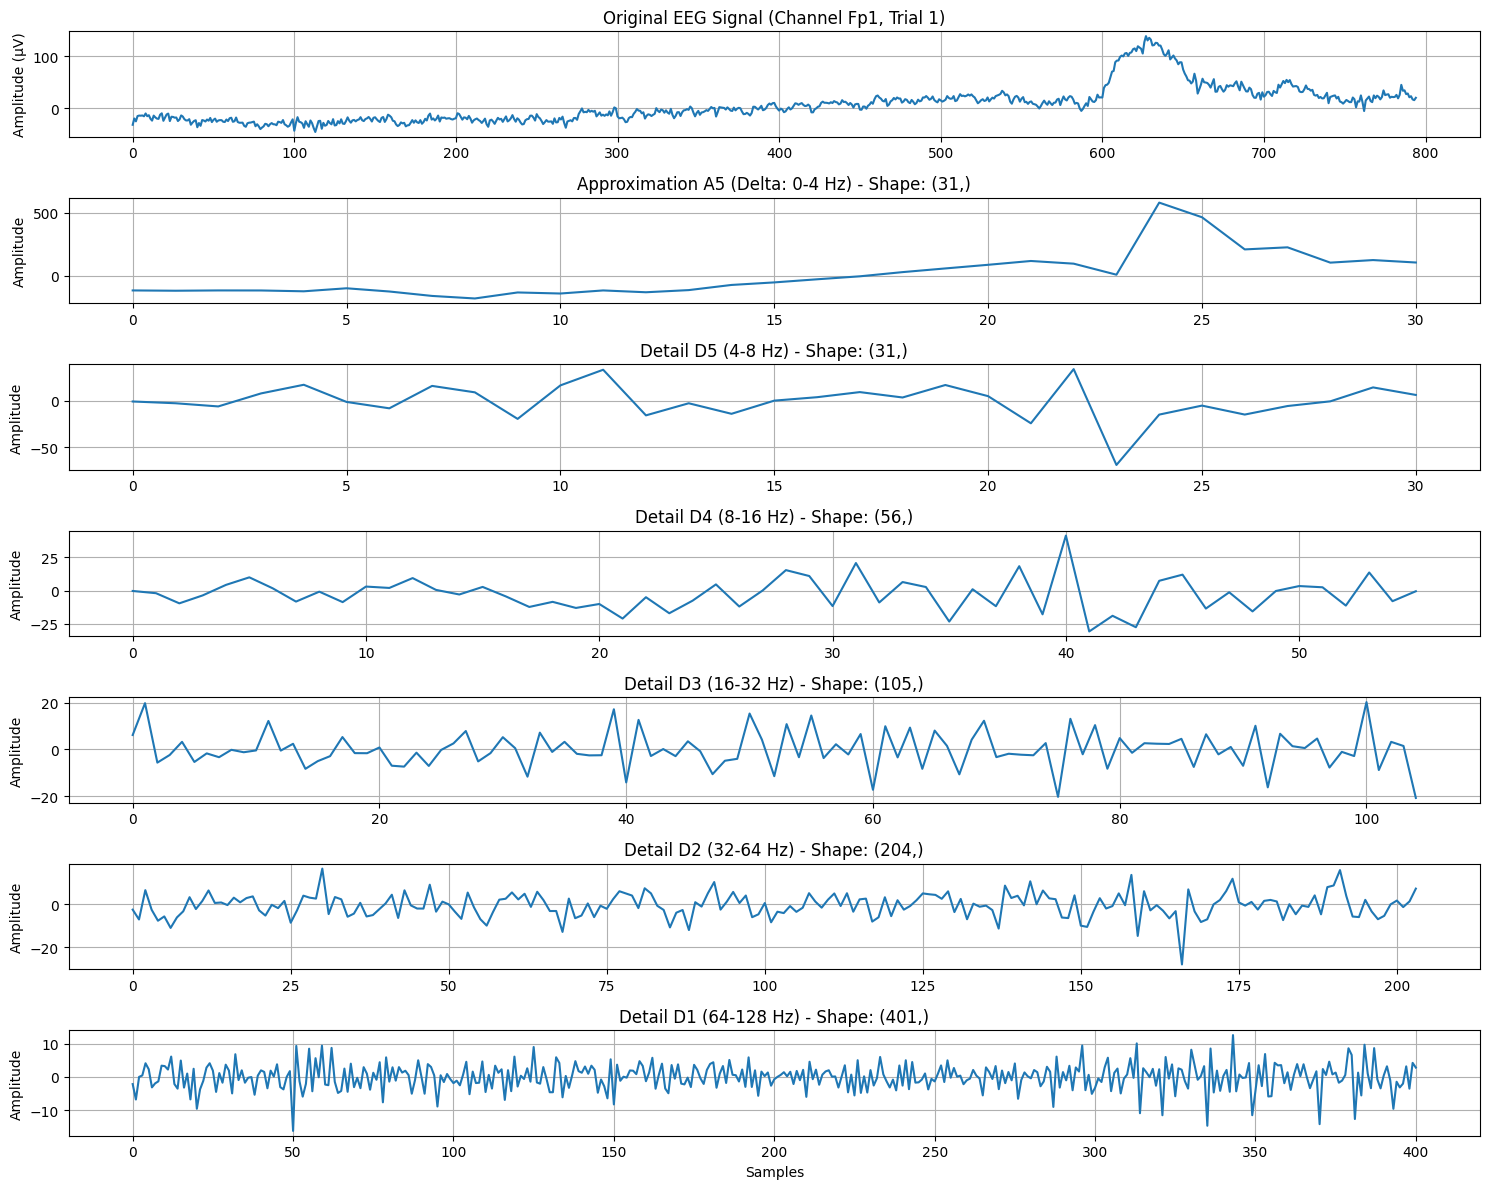

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Load your processed features to get one sample
data = np.load("processed_features.npz")
X = data['features']  # Shape: (3107, 1280)

# Take one sample to visualize
sample_idx = 5
single_sample = X[sample_idx]

print(f"Single sample shape: {single_sample.shape}")

# Since your features are organized as: 64 channels × 5 bands × 4 features
# Let's reconstruct what the DWT coefficients looked like for one channel

# Parameters from your preprocessing
WAVELET_NAME = 'db4'
DWT_LEVEL = 5
SFREQ = 256.0

# Let's take one channel from your original data to show DWT decomposition
mat_data = scipy.io.loadmat("BCI2020 EEG Signal for Words/Training set/Data_Sample01.mat")
eeg_data = mat_data['epo_train']['x'][0][0]  # Shape: (795, 64, 300)

# Take first channel from first trial for demonstration
original_signal = eeg_data[:, 0, 0]  # Shape: (795,)

# Perform DWT decomposition
coeffs = pywt.wavedec(original_signal, WAVELET_NAME, level=DWT_LEVEL)
print(f"DWT coefficients levels: {len(coeffs)}")
print(f"Coefficient shapes: {[c.shape for c in coeffs]}")

# Frequency bands for 256 Hz sampling rate
freq_bands = {
    'D1': (64, 128),    # Gamma2
    'D2': (32, 64),     # Gamma1
    'D3': (16, 32),     # Beta
    'D4': (8, 16),      # Alpha
    'D5': (4, 8),       # Theta
    'A5': (0, 4)        # Delta
}

# Plot the DWT decomposition
fig, axes = plt.subplots(len(coeffs) + 1, 1, figsize=(15, 12))

# Plot original signal
axes[0].plot(original_signal)
axes[0].set_title('Original EEG Signal (Channel Fp1, Trial 1)')
axes[0].set_ylabel('Amplitude (μV)')
axes[0].grid(True)

# Plot approximation coefficients (A5 - Delta)
axes[1].plot(coeffs[0])
axes[1].set_title(f'Approximation A5 (Delta: 0-4 Hz) - Shape: {coeffs[0].shape}')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True)

# Plot detail coefficients (D5 to D1)
for i in range(1, len(coeffs)):
    band_name = f'D{len(coeffs)-i}'
    freq_range = freq_bands.get(band_name, ('?', '?'))
    axes[i+1].plot(coeffs[i])
    axes[i+1].set_title(f'Detail {band_name} ({freq_range[0]}-{freq_range[1]} Hz) - Shape: {coeffs[i].shape}')
    axes[i+1].set_ylabel('Amplitude')
    axes[i+1].grid(True)

plt.xlabel('Samples')
plt.tight_layout()
plt.show()

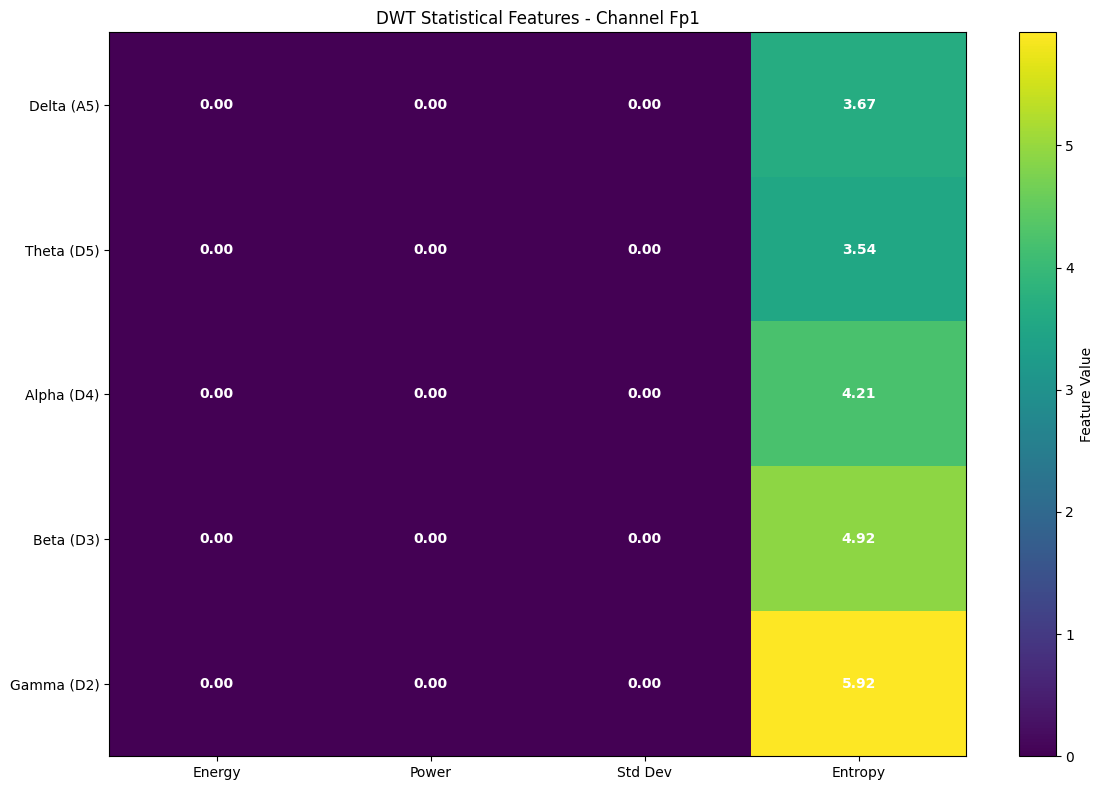

In [4]:
# Let's visualize the 4 statistical features for one channel across all 5 bands
def plot_dwt_features_for_channel(feature_vector, channel_idx=0):
    """
    Plot the 4 statistical features for a specific channel across all 5 DWT bands
    """
    # Each channel has: 5 bands × 4 features = 20 features
    start_idx = channel_idx * 20
    channel_features = feature_vector[start_idx:start_idx + 20]
    
    # Reshape to (5 bands, 4 features)
    feature_matrix = channel_features.reshape(5, 4)
    
    bands = ['Delta (A5)', 'Theta (D5)', 'Alpha (D4)', 'Beta (D3)', 'Gamma (D2)']
    features = ['Energy', 'Power', 'Std Dev', 'Entropy']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(feature_matrix, cmap='viridis', aspect='auto')
    
    # Set labels
    ax.set_xticks(np.arange(len(features)))
    ax.set_yticks(np.arange(len(bands)))
    ax.set_xticklabels(features)
    ax.set_yticklabels(bands)
    
    # Add text annotations
    for i in range(len(bands)):
        for j in range(len(features)):
            text = ax.text(j, i, f'{feature_matrix[i, j]:.2f}',
                          ha="center", va="center", color="w", fontweight='bold')
    
    plt.title(f'DWT Statistical Features - Channel {channel_names[channel_idx]}')
    plt.colorbar(im, label='Feature Value')
    plt.tight_layout()
    plt.show()

# Plot for first channel
plot_dwt_features_for_channel(single_sample, channel_idx=0)

In [5]:
# Compare DWT features across different classes
def compare_class_features(X, y, feature_type='energy'):
    """
    Compare a specific feature type across different classes
    """
    feature_idx_map = {
        'energy': 0,
        'power': 1, 
        'std_dev': 2,
        'entropy': 3
    }
    
    feature_idx = feature_idx_map[feature_type]
    
    plt.figure(figsize=(15, 10))
    
    # For first 5 channels
    for channel in range(5):
        plt.subplot(2, 3, channel + 1)
        
        # Extract the specific feature for this channel across all bands and classes
        for class_label in np.unique(y):
            class_samples = X[y == class_label]
            
            # Get the feature values for this channel (every 4th feature starting at feature_idx)
            channel_features = []
            for sample in class_samples:
                start_idx = channel * 20 + feature_idx  # Start position for this channel + feature type
                feature_vals = sample[start_idx::4]  # Get every 4th value (same feature type across bands)
                channel_features.extend(feature_vals)
            
            plt.hist(channel_features, alpha=0.7, label=f'Class {class_label}', bins=20)
        
        plt.title(f'Channel {channel_names[channel]}')
        plt.xlabel(f'{feature_type.title()} Value')
        plt.ylabel('Frequency')
        if channel == 0:
            plt.legend()
    
    plt.suptitle(f'Distribution of {feature_type.title()} Feature Across Classes (First 5 Channels)')
    plt.tight_layout()
    plt.show()

# Compare energy features across classes
compare_class_features(X, y, feature_type='energy')

NameError: name 'y' is not defined

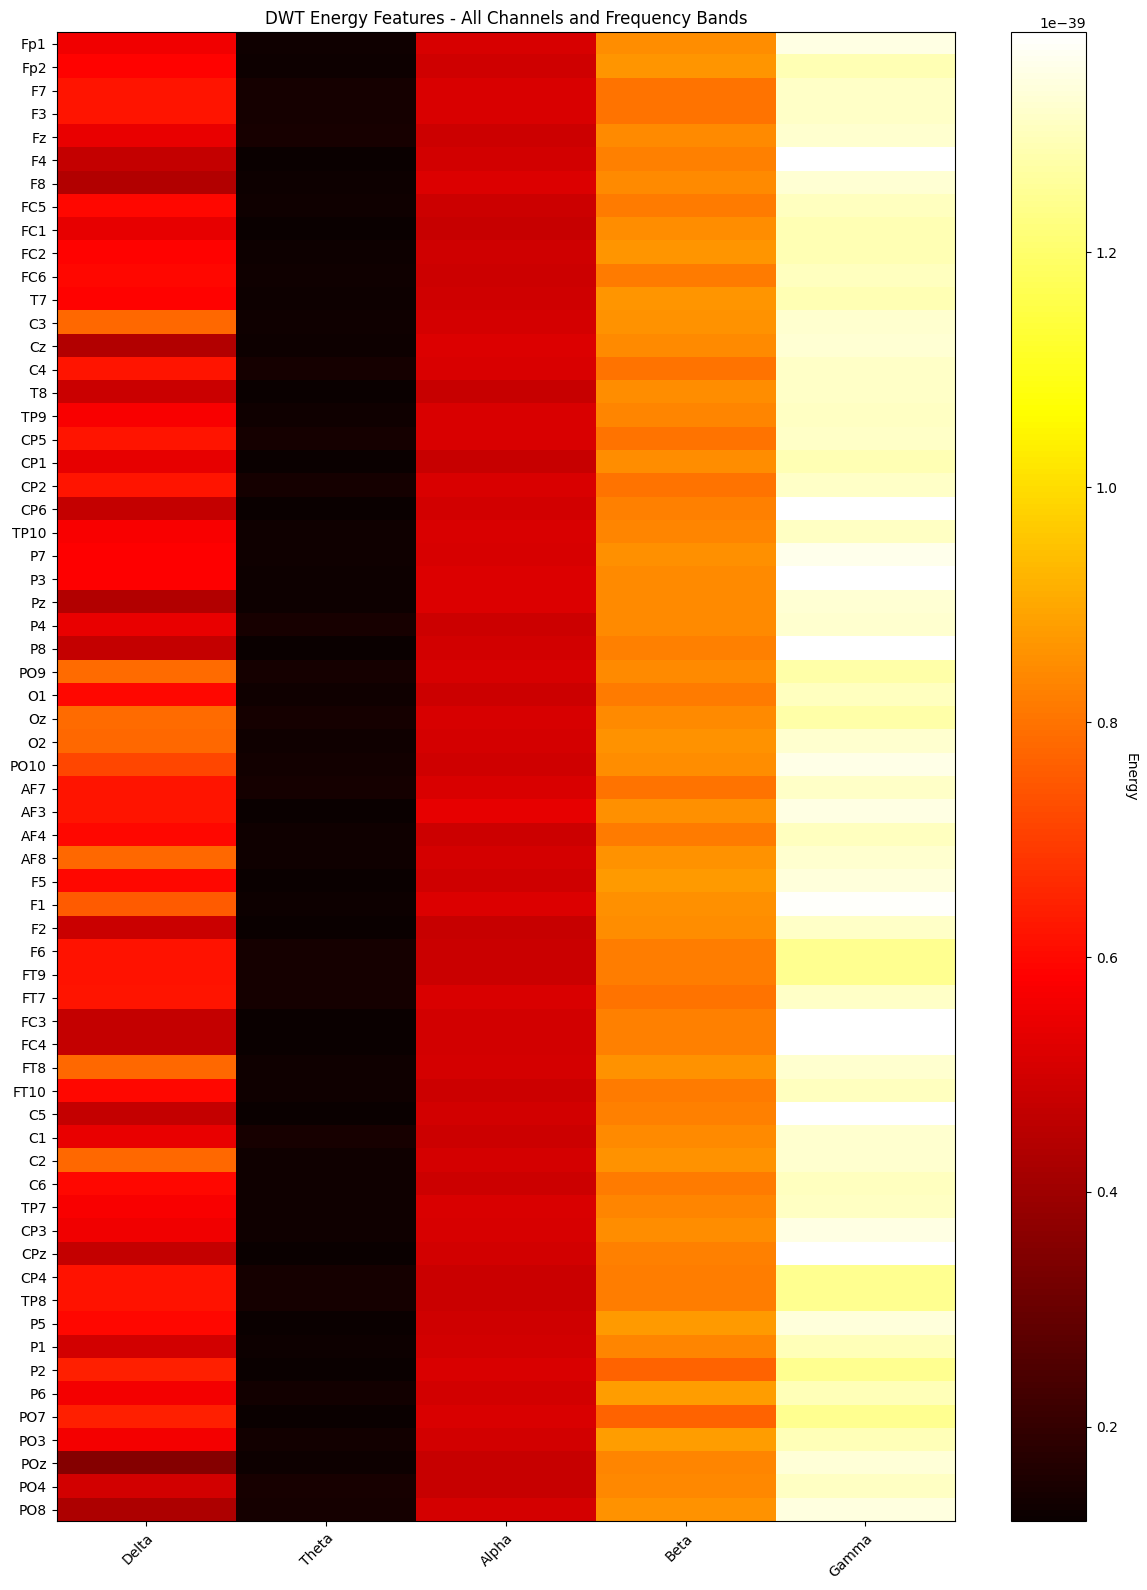

In [6]:
# Create a heatmap of energy features for all channels
def plot_energy_heatmap(sample_features, channel_names):
    """
    Plot energy features as a heatmap across all channels and bands
    """
    # Reshape: 64 channels × 5 bands
    energy_features = sample_features[0::4]  # Take every 4th feature (energy)
    energy_matrix = energy_features.reshape(64, 5)
    
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    
    fig, ax = plt.subplots(figsize=(12, 16))
    im = ax.imshow(energy_matrix, cmap='hot', aspect='auto')
    
    # Set labels
    ax.set_xticks(np.arange(len(bands)))
    ax.set_yticks(np.arange(len(channel_names)))
    ax.set_xticklabels(bands)
    ax.set_yticklabels(channel_names)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Energy', rotation=-90, va="bottom")
    
    plt.title('DWT Energy Features - All Channels and Frequency Bands')
    plt.tight_layout()
    plt.show()

# Plot for first sample
plot_energy_heatmap(single_sample, data['channel_names'])

EEG data shape: (795, 64, 300)
Channel names: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2']...
Creating simple brain heatmap...


/tmp/ipykernel_1561/1545646504.py:195: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', 256)


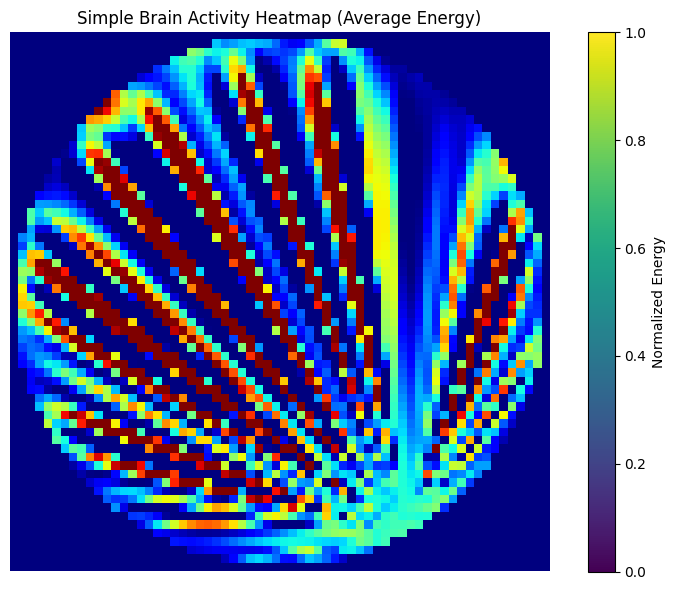


Creating DWT-based brain heatmaps...
Creating 4 brain heatmaps for 300 trials...
Frequency band: alpha, Window samples: 198


/home/darkrai/tfenv/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/tmp/ipykernel_1561/1545646504.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', 256)


First map - Min: 0.000, Max: 0.966, Mean: 0.295
Created heatmaps shape: (100, 100, 3, 4, 300)


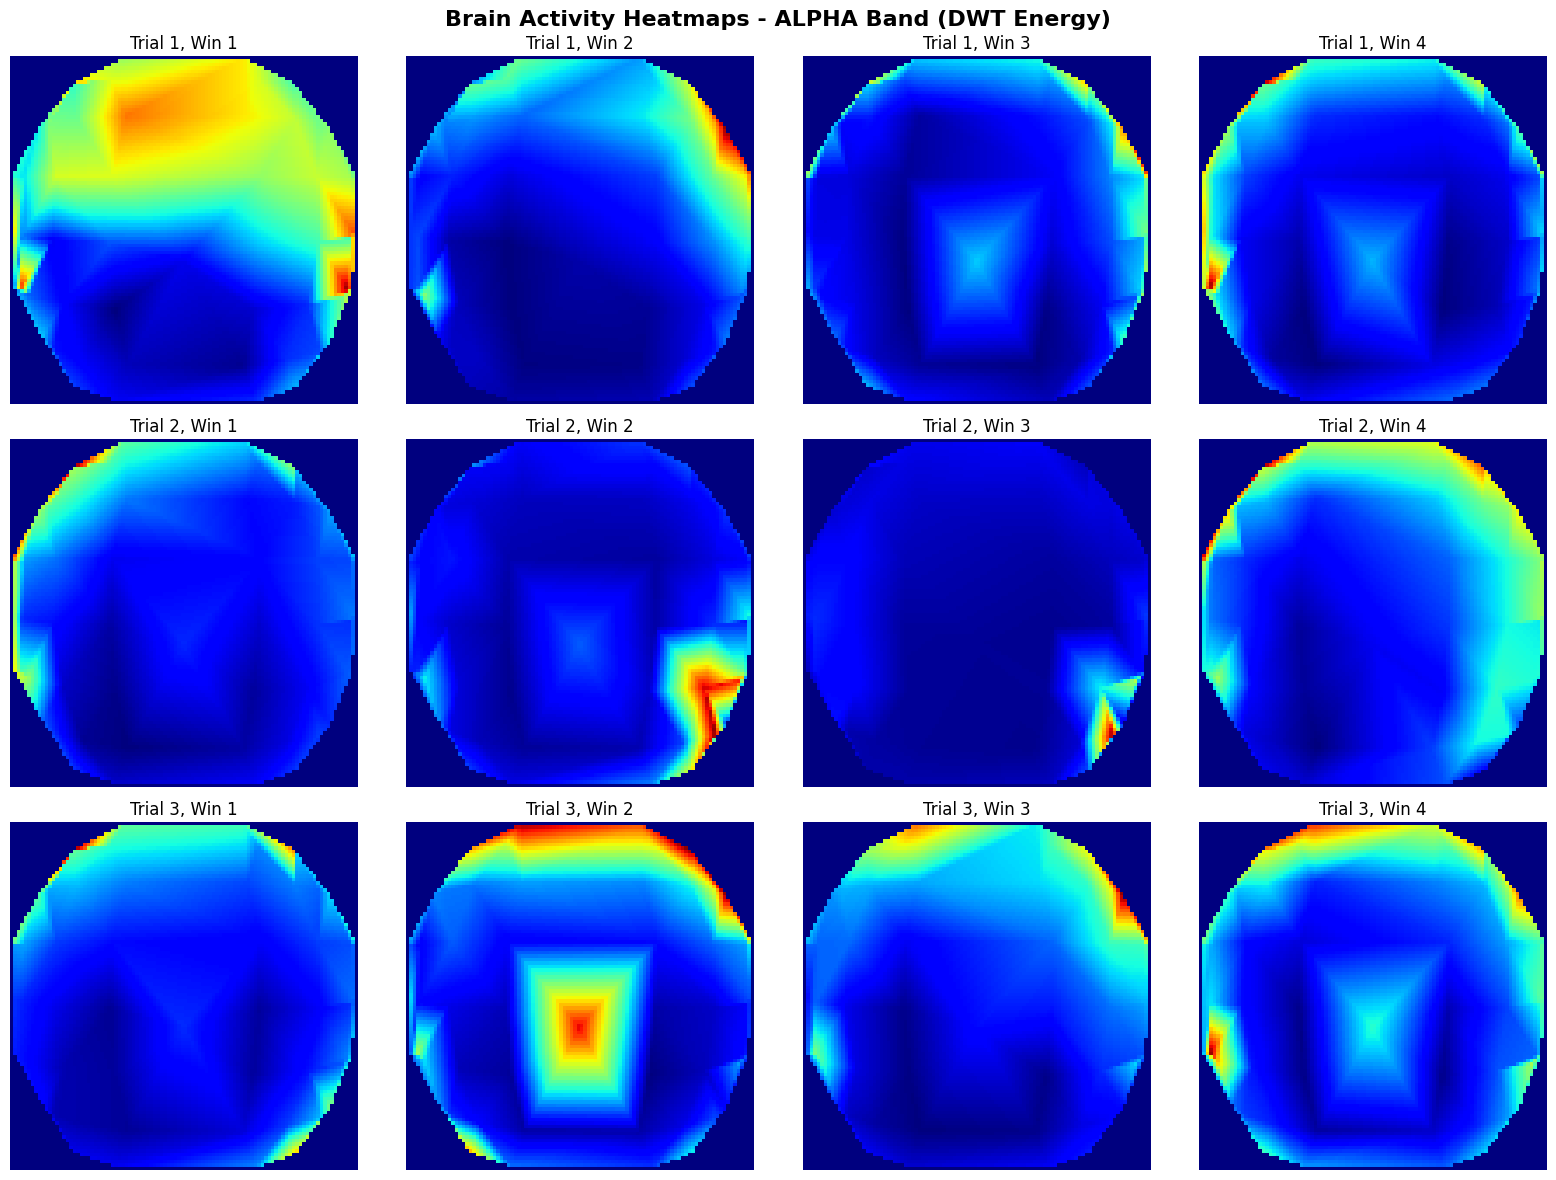

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.cm as cm
import mne
import pywt

def create_dwt_brain_heatmaps(eeg_data_3d, channel_names, labels, frequency_band='alpha', 
                             sample_rate=256.0, n_maps=5, map_size=64):
    """
    Create brain activity heatmaps from DWT features
    """
    # Frequency band to DWT coefficient mapping
    band_to_coeff = {
        'delta': 0,   # A5
        'theta': 1,   # D5
        'alpha': 2,   # D4
        'beta': 3,    # D3
        'gamma': 4    # D2
    }
    
    coeff_idx = band_to_coeff[frequency_band]
    WAVELET_NAME = 'db4'
    DWT_LEVEL = 5
    
    # Get standard channel positions from MNE - CORRECTED APPROACH
    try:
        # Create a temporary info structure to get channel positions
        info = mne.create_info(ch_names=channel_names, sfreq=sample_rate, ch_types='eeg')
        montage = mne.channels.make_standard_montage('standard_1020')
        
        # Set montage to get proper channel locations
        info.set_montage(montage)
        
        # Get channel positions
        ch_positions = {}
        for ch_name in channel_names:
            try:
                # Get channel index in the montage
                idx = montage.ch_names.index(ch_name.upper())
                ch_positions[ch_name] = montage.dig[idx+3]['r'][:2]  # Skip first 3 reference points
            except (ValueError, IndexError):
                # If channel not found in standard montage, use approximate position
                print(f"Warning: Channel {ch_name} not found in standard montage, using default position")
                ch_positions[ch_name] = [0, 0]
                
    except Exception as e:
        print(f"Error setting up montage: {e}")
        # Fallback: create approximate positions
        ch_positions = {}
        n_channels = len(channel_names)
        for i, ch_name in enumerate(channel_names):
            angle = 2 * np.pi * i / n_channels
            ch_positions[ch_name] = [np.cos(angle), np.sin(angle)]
    
    # Convert to arrays for interpolation
    x_vals = np.array([ch_positions[ch][0] for ch in channel_names])
    y_vals = np.array([ch_positions[ch][1] for ch in channel_names])
    
    # Normalize coordinates to [0, 1] range
    x_vals = (x_vals - x_vals.min()) / (x_vals.max() - x_vals.min())
    y_vals = (y_vals - y_vals.min()) / (y_vals.max() - y_vals.min())
    
    # Create grid for interpolation
    xi = np.linspace(0, 1, map_size)
    yi = np.linspace(0, 1, map_size)
    xi, yi = np.meshgrid(xi, yi)
    
    n_trials = eeg_data_3d.shape[2]
    n_timepoints = eeg_data_3d.shape[0]
    
    # Calculate window parameters
    win_samples = n_timepoints // n_maps
    step_samples = win_samples
    
    # Initialize output array
    topo_maps_rgb = np.zeros((map_size, map_size, 3, n_maps, n_trials))
    
    print(f"Creating {n_maps} brain heatmaps for {n_trials} trials...")
    print(f"Frequency band: {frequency_band}, Window samples: {win_samples}")
    
    for trial_idx in range(min(10, n_trials)):  # Process first 10 trials for demo
        trial_data = eeg_data_3d[:, :, trial_idx]  # Shape: (n_timepoints, n_channels)
        
        for window_idx in range(n_maps):
            start_sample = window_idx * step_samples
            end_sample = start_sample + win_samples
            
            if end_sample > n_timepoints:
                break
            
            # Extract time window
            window_data = trial_data[start_sample:end_sample, :]  # Shape: (win_samples, n_channels)
            
            # Calculate DWT features for this window
            window_dwt_features = []
            
            for channel_idx in range(len(channel_names)):
                channel_signal = window_data[:, channel_idx]
                
                try:
                    # Perform DWT
                    coeffs = pywt.wavedec(channel_signal, WAVELET_NAME, level=DWT_LEVEL)
                    
                    # Get the coefficient for the selected frequency band
                    if len(coeffs) > coeff_idx:
                        band_coeff = coeffs[coeff_idx]
                        
                        # Calculate energy for this band
                        energy = np.sum(band_coeff**2)
                        window_dwt_features.append(energy)
                    else:
                        window_dwt_features.append(0.0)
                        
                except Exception as e:
                    print(f"Error processing channel {channel_idx}: {e}")
                    window_dwt_features.append(0.0)
            
            # Convert to numpy array
            dwt_features = np.array(window_dwt_features)
            
            # Normalize features for better visualization
            if dwt_features.max() > dwt_features.min():
                dwt_features = (dwt_features - dwt_features.min()) / (dwt_features.max() - dwt_features.min())
            else:
                dwt_features = np.zeros_like(dwt_features)
            
            # Interpolate to 2D grid
            zi = griddata((x_vals, y_vals), dwt_features, (xi, yi), method='linear', fill_value=0)
            
            # Apply colormap
            cmap = cm.get_cmap('jet', 256)
            rgb_map = cmap(zi)[:, :, :3]  # Remove alpha channel
            
            # Store the map
            topo_maps_rgb[:, :, :, window_idx, trial_idx] = rgb_map
            
            if trial_idx == 0 and window_idx == 0:
                print(f"First map - Min: {zi.min():.3f}, Max: {zi.max():.3f}, Mean: {zi.mean():.3f}")
    
    return topo_maps_rgb, xi, yi

def plot_brain_heatmap_samples(topo_maps_rgb, frequency_band, n_trials=3, n_maps=4):
    """
    Plot multiple brain heatmap samples
    """
    fig, axes = plt.subplots(n_trials, n_maps, figsize=(4*n_maps, 4*n_trials))
    
    if n_trials == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_trials):
        for j in range(n_maps):
            ax = axes[i, j] if n_trials > 1 else axes[j]
            img = topo_maps_rgb[:, :, :, j, i]
            ax.imshow(img)
            ax.set_title(f'Trial {i+1}, Win {j+1}')
            ax.axis('off')
    
    plt.suptitle(f'Brain Activity Heatmaps - {frequency_band.upper()} Band (DWT Energy)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def create_simple_brain_heatmaps(eeg_data_3d, channel_names, sample_rate=256.0):
    """
    Simplified version for quick testing
    """
    # Use a simple circular layout for channel positions
    n_channels = len(channel_names)
    angles = np.linspace(0, 2*np.pi, n_channels, endpoint=False)
    x_vals = np.cos(angles)
    y_vals = np.sin(angles)
    
    # Normalize to [0,1]
    x_vals = (x_vals - x_vals.min()) / (x_vals.max() - x_vals.min())
    y_vals = (y_vals - y_vals.min()) / (y_vals.max() - y_vals.min())
    
    map_size = 64
    xi = np.linspace(0, 1, map_size)
    yi = np.linspace(0, 1, map_size)
    xi, yi = np.meshgrid(xi, yi)
    
    # Take first trial and calculate average energy per channel
    trial_data = eeg_data_3d[:, :, 0]  # First trial
    channel_energies = np.mean(trial_data**2, axis=0)  # Average energy per channel
    
    # Normalize
    channel_energies = (channel_energies - channel_energies.min()) / (channel_energies.max() - channel_energies.min())
    
    # Interpolate
    zi = griddata((x_vals, y_vals), channel_energies, (xi, yi), method='cubic', fill_value=0)
    
    # Create RGB map
    cmap = cm.get_cmap('jet', 256)
    rgb_map = cmap(zi)[:, :, :3]
    
    return rgb_map, xi, yi

# Quick test with your data
if __name__ == '__main__':
    # Load your data
    import scipy.io
    mat_data = scipy.io.loadmat("BCI2020 EEG Signal for Words/Training set/Data_Sample01.mat")
    eeg_data = mat_data['epo_train']['x'][0][0]  # Shape: (795, 64, 300)
    
    # Extract channel names
    mnt_data = mat_data['mnt']
    channel_names = []
    for i in range(64):
        channel_array = mnt_data['clab'][0][0][0][i]
        channel_names.append(str(channel_array[0]))
    
    print(f"EEG data shape: {eeg_data.shape}")
    print(f"Channel names: {channel_names[:10]}...")
    
    # Try the simple version first
    print("Creating simple brain heatmap...")
    simple_map, xi, yi = create_simple_brain_heatmaps(eeg_data, channel_names)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(simple_map, extent=[0, 1, 0, 1])
    plt.title('Simple Brain Activity Heatmap (Average Energy)')
    plt.colorbar(label='Normalized Energy')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Now try the full DWT version
    print("\nCreating DWT-based brain heatmaps...")
    try:
        topo_maps, xi, yi = create_dwt_brain_heatmaps(
            eeg_data, 
            channel_names, 
            labels=np.argmax(mat_data['epo_train']['y'][0][0], axis=0),
            frequency_band='alpha',
            sample_rate=256.0,
            n_maps=4,
            map_size=100
        )
        
        print(f"Created heatmaps shape: {topo_maps.shape}")
        
        # Plot samples
        plot_brain_heatmap_samples(topo_maps, 'alpha', n_trials=3, n_maps=4)
        
    except Exception as e:
        print(f"Error in DWT heatmap creation: {e}")
        import traceback
        traceback.print_exc()

Processing 64 channels: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5']...
Creating 4 brain heatmaps for 300 trials...
Frequency band: alpha, Window samples: 198
Created heatmaps shape: (100, 100, 3, 4, 300)


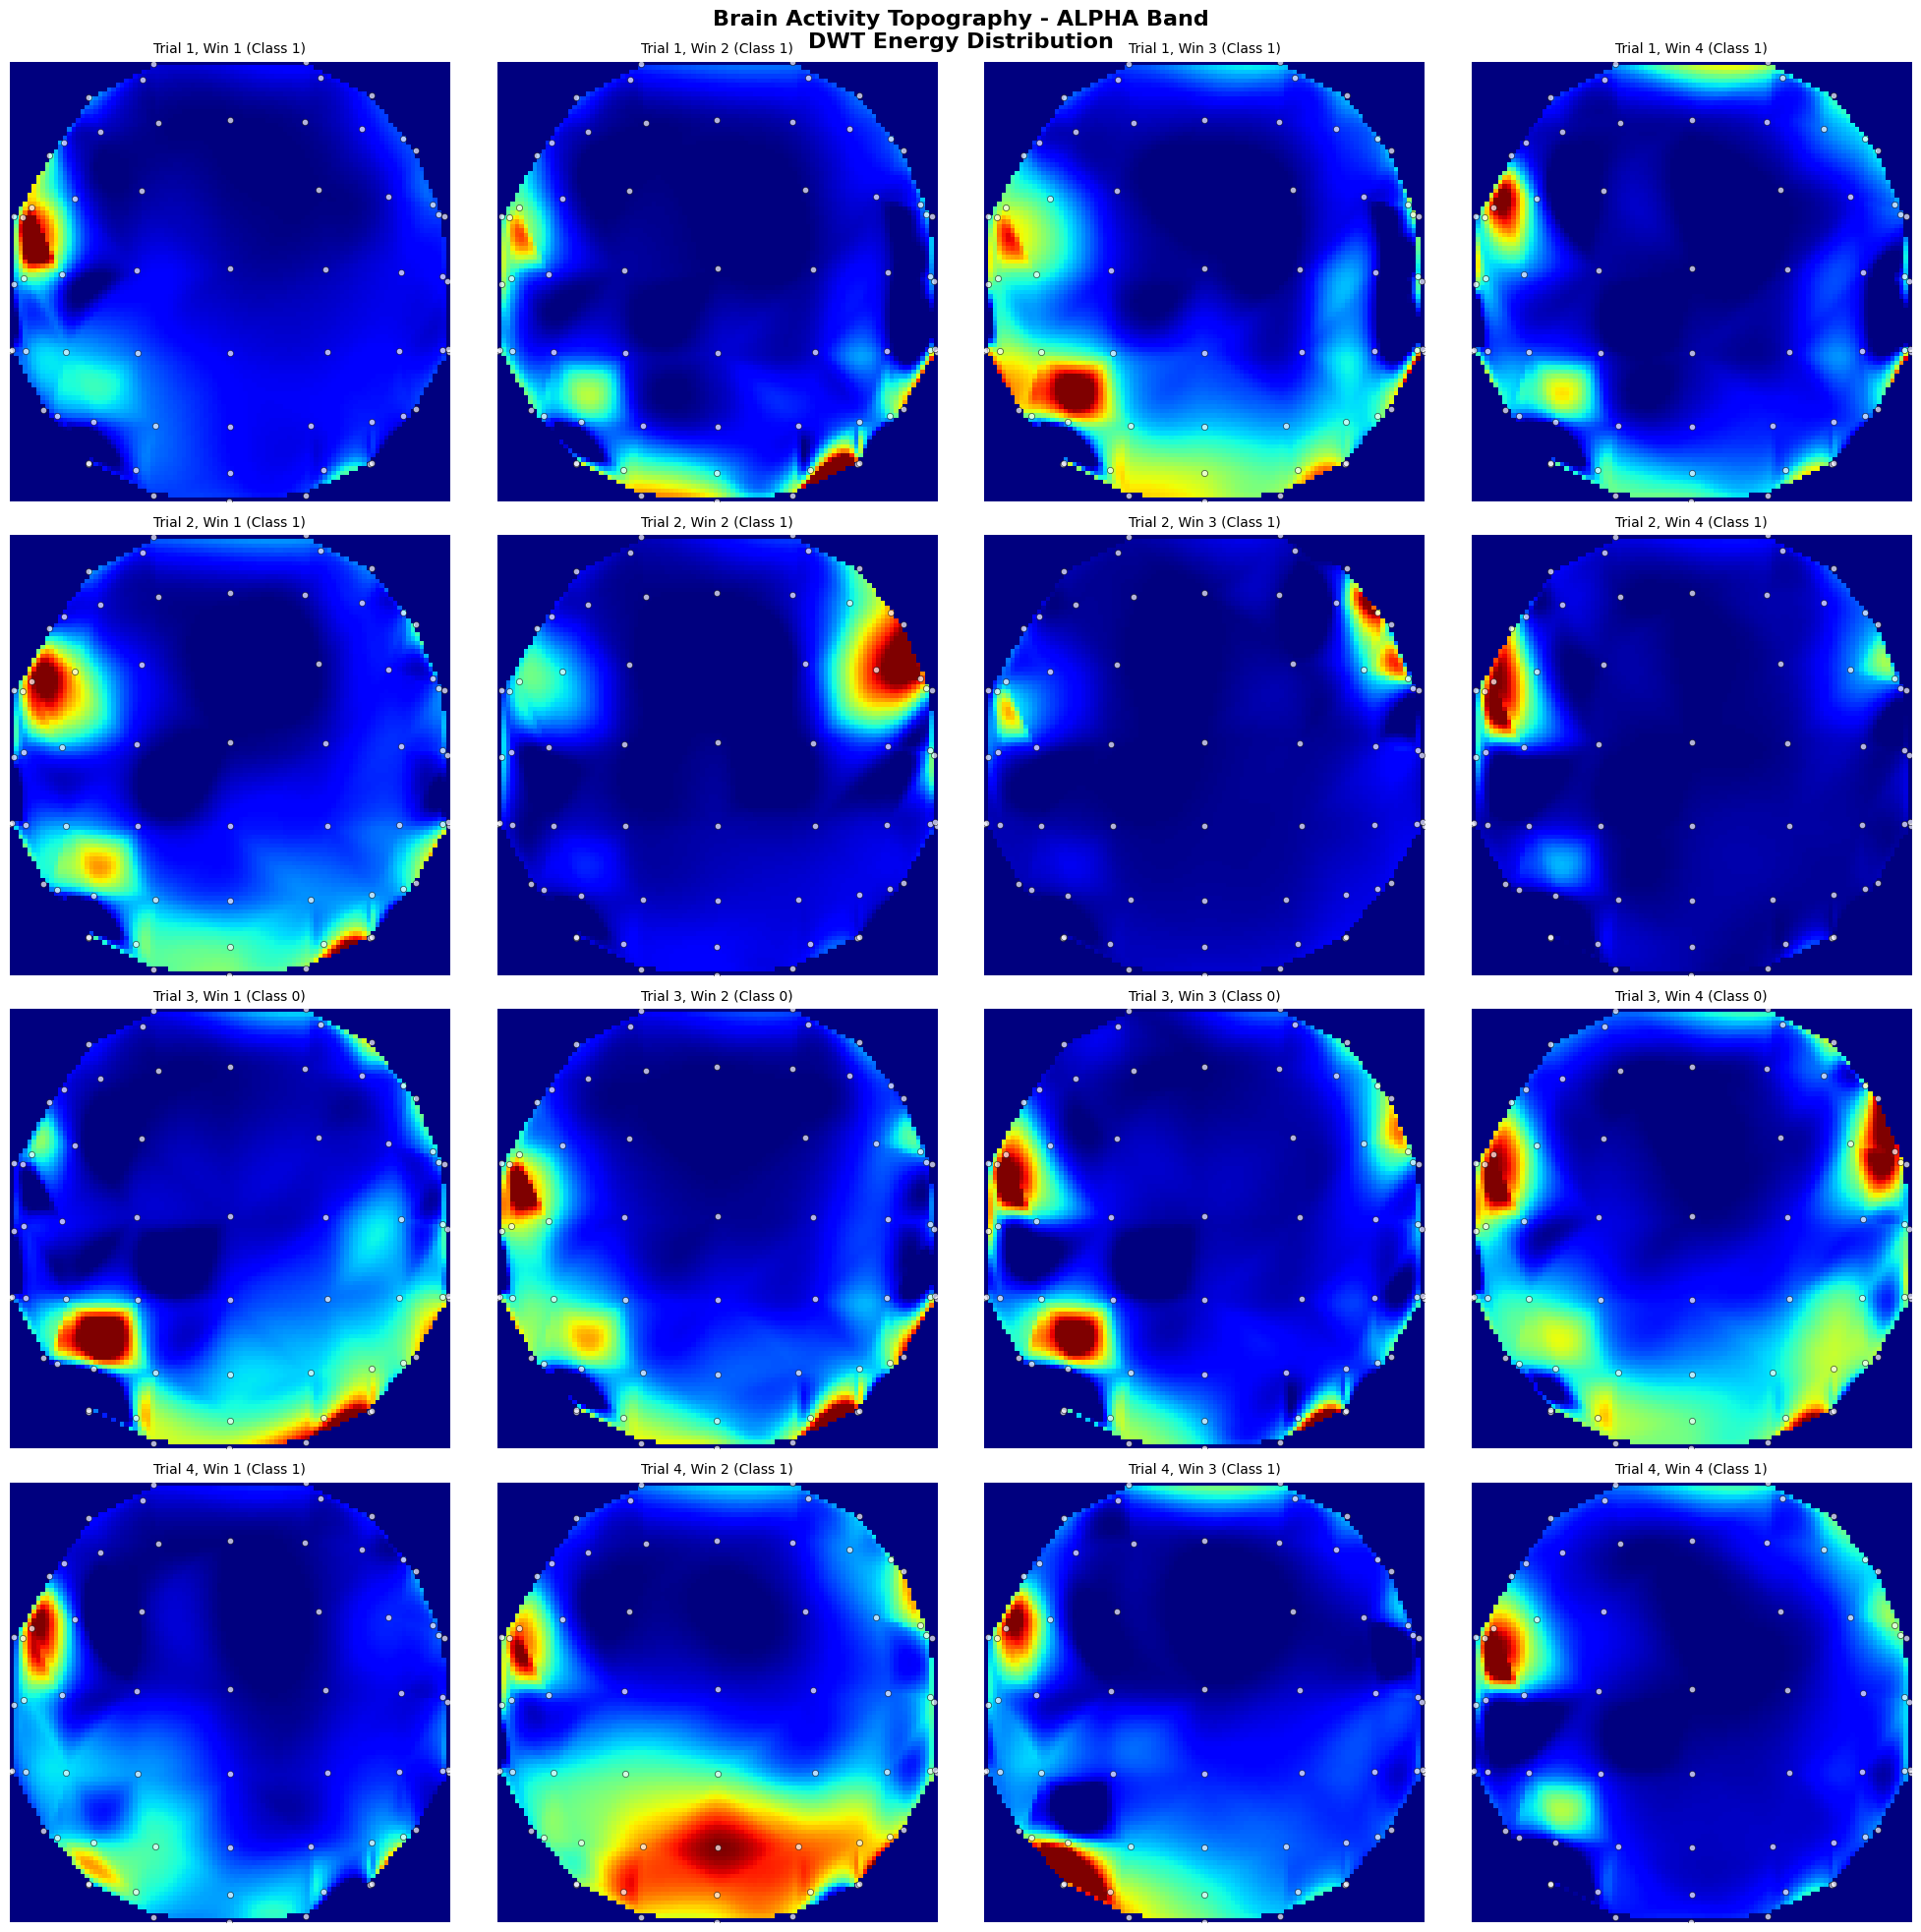

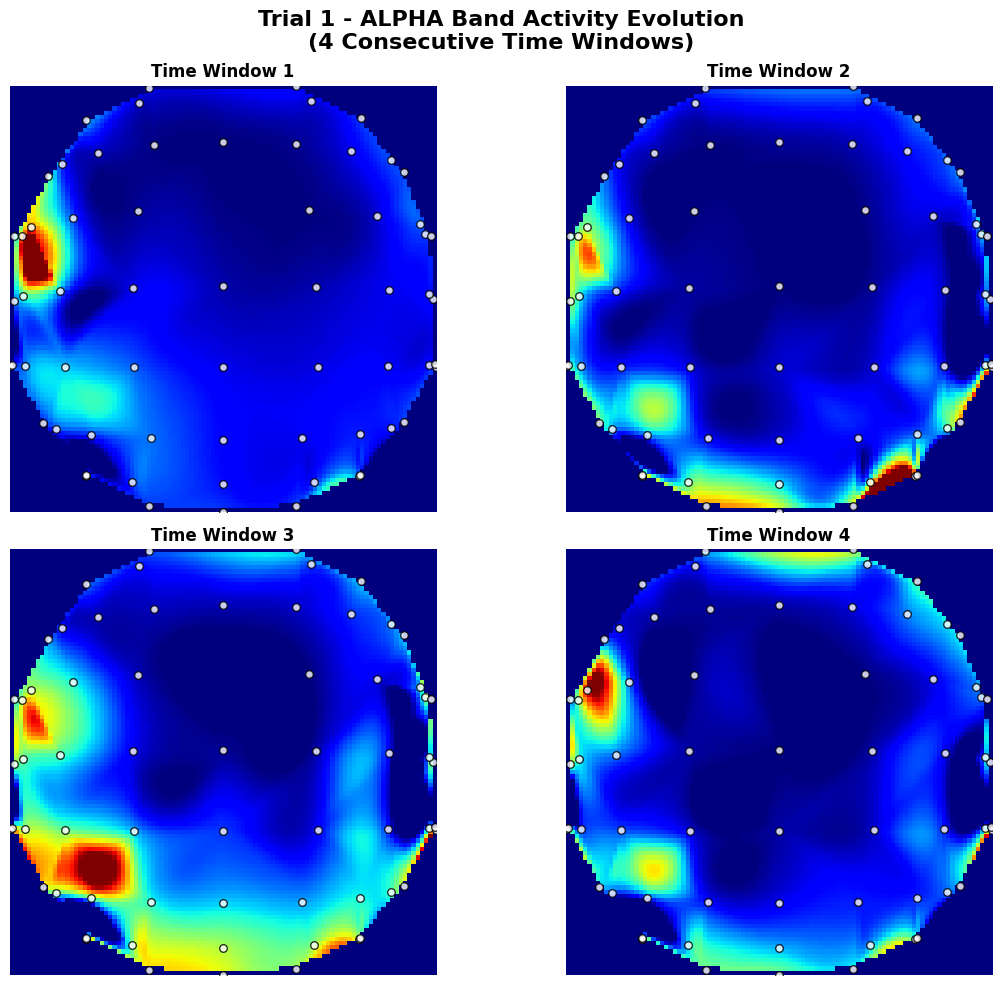


Creating comparison across frequency bands...
Creating 1 brain heatmaps for 1 trials...
Frequency band: delta, Window samples: 795
Creating 1 brain heatmaps for 1 trials...
Frequency band: theta, Window samples: 795
Creating 1 brain heatmaps for 1 trials...
Frequency band: alpha, Window samples: 795
Creating 1 brain heatmaps for 1 trials...
Frequency band: beta, Window samples: 795


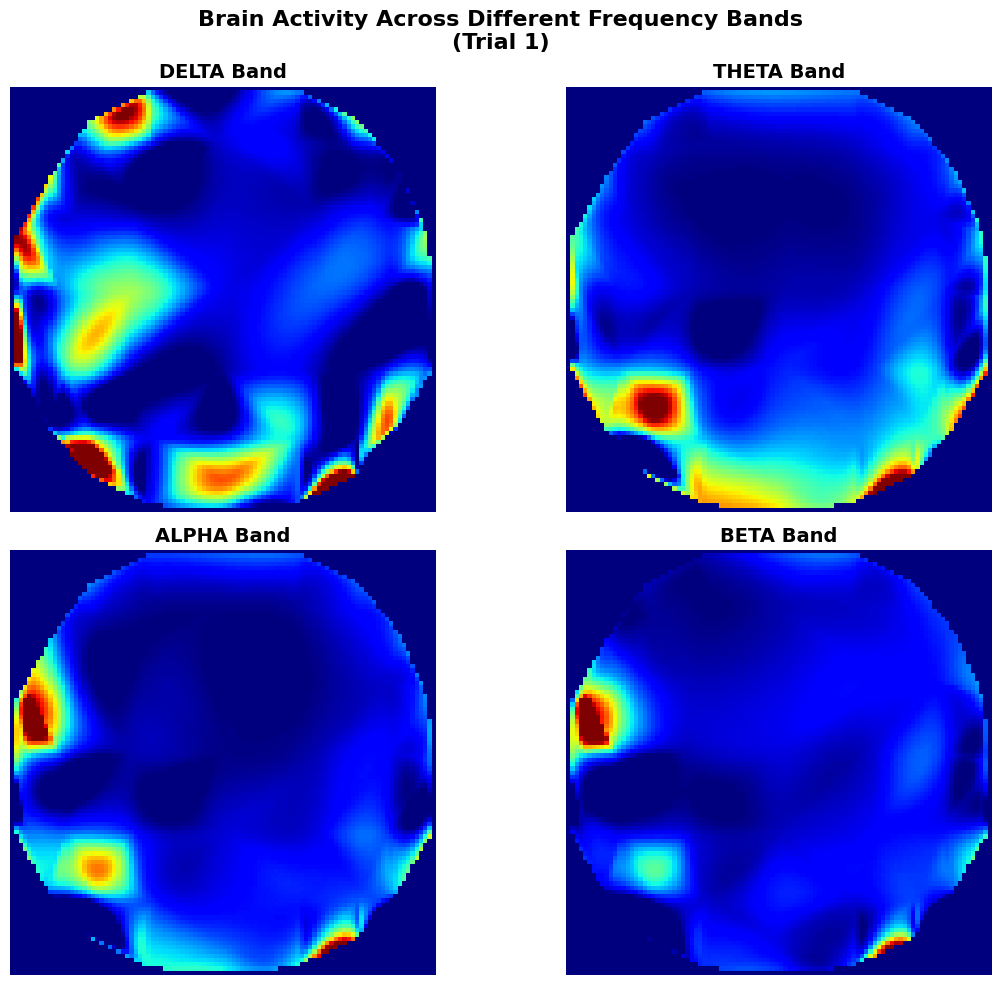

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
import mne
import pywt

def create_dwt_brain_heatmaps_fixed(eeg_data_3d, channel_names, labels, frequency_band='alpha', 
                                   sample_rate=256.0, n_maps=4, map_size=100, max_trials=300):
    """
    Create brain activity heatmaps from DWT features with proper channel mapping
    """
    # Frequency band to DWT coefficient mapping
    band_to_coeff = {
        'delta': 0,   # A5
        'theta': 1,   # D5
        'alpha': 2,   # D4
        'beta': 3,    # D3
        'gamma': 4    # D2
    }
    
    coeff_idx = band_to_coeff[frequency_band]
    WAVELET_NAME = 'db4'
    DWT_LEVEL = 4  # Reduced to avoid boundary effects
    
    # Create a mapping from your channel names to standard names
    channel_mapping = {
        'Fp1': 'Fp1', 'Fp2': 'Fp2', 'F7': 'F7', 'F3': 'F3', 'Fz': 'Fz',
        'F4': 'F4', 'F8': 'F8', 'FC5': 'FC5', 'FC1': 'FC1', 'FC2': 'FC2',
        'FC6': 'FC6', 'T7': 'T7', 'C3': 'C3', 'Cz': 'Cz', 'C4': 'C4',
        'T8': 'T8', 'TP9': 'TP9', 'CP5': 'CP5', 'CP1': 'CP1', 'CP2': 'CP2',
        'CP6': 'CP6', 'TP10': 'TP10', 'P7': 'P7', 'P3': 'P3', 'Pz': 'Pz',
        'P4': 'P4', 'P8': 'P8', 'PO9': 'PO9', 'O1': 'O1', 'Oz': 'Oz',
        'O2': 'O2', 'PO10': 'PO10', 'AF7': 'AF7', 'AF3': 'AF3', 'AF4': 'AF4',
        'AF8': 'AF8', 'F5': 'F5', 'F1': 'F1', 'F2': 'F2', 'F6': 'F6',
        'FT9': 'FT9', 'FT7': 'FT7', 'FC3': 'FC3', 'FC4': 'FC4', 'FT8': 'FT8',
        'FT10': 'FT10', 'C5': 'C5', 'C1': 'C1', 'C2': 'C2', 'C6': 'C6',
        'TP7': 'TP7', 'CP3': 'CP3', 'CPz': 'CPz', 'CP4': 'CP4', 'TP8': 'TP8',
        'P5': 'P5', 'P1': 'P1', 'P2': 'P2', 'P6': 'P6', 'PO7': 'PO7',
        'PO3': 'PO3', 'POz': 'POz', 'PO4': 'PO4', 'PO8': 'PO8'
    }
    
    # Get standard channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    
    # Create channel coordinates dictionary
    ch_positions = {}
    for ch_name in channel_names:
        standard_name = channel_mapping.get(ch_name, ch_name)
        try:
            idx = montage.ch_names.index(standard_name)
            # Get the position (skip first 3 which are reference points)
            ch_positions[ch_name] = montage.dig[idx+3]['r'][:2]
        except (ValueError, IndexError):
            # Use approximate position based on channel name pattern
            print(f"Channel {ch_name} not found, using approximate position")
            # Create circular layout as fallback
            angle = 2 * np.pi * len(ch_positions) / len(channel_names)
            ch_positions[ch_name] = [np.cos(angle), np.sin(angle)]
    
    # Convert to arrays for interpolation
    x_vals = np.array([ch_positions[ch][0] for ch in channel_names])
    y_vals = np.array([ch_positions[ch][1] for ch in channel_names])
    
    # Normalize coordinates to [0, 1] range
    x_vals = (x_vals - x_vals.min()) / (x_vals.max() - x_vals.min())
    y_vals = (y_vals - y_vals.min()) / (y_vals.max() - y_vals.min())
    
    # Create grid for interpolation
    xi = np.linspace(0, 1, map_size)
    yi = np.linspace(0, 1, map_size)
    xi, yi = np.meshgrid(xi, yi)
    
    n_trials = min(eeg_data_3d.shape[2], max_trials)  # Limit for demo
    n_timepoints = eeg_data_3d.shape[0]
    
    # Calculate window parameters
    win_samples = n_timepoints // n_maps
    step_samples = win_samples
    
    # Initialize output array
    topo_maps_rgb = np.zeros((map_size, map_size, 3, n_maps, n_trials))
    
    print(f"Creating {n_maps} brain heatmaps for {n_trials} trials...")
    print(f"Frequency band: {frequency_band}, Window samples: {win_samples}")
    
    for trial_idx in range(n_trials):
        trial_data = eeg_data_3d[:, :, trial_idx]
        
        for window_idx in range(n_maps):
            start_sample = window_idx * step_samples
            end_sample = start_sample + win_samples
            
            # Extract time window
            window_data = trial_data[start_sample:end_sample, :]
            
            # Calculate DWT features for this window
            window_dwt_features = []
            
            for channel_idx in range(len(channel_names)):
                channel_signal = window_data[:, channel_idx]
                
                try:
                    # Perform DWT with error handling
                    coeffs = pywt.wavedec(channel_signal, WAVELET_NAME, level=DWT_LEVEL)
                    
                    if len(coeffs) > coeff_idx:
                        band_coeff = coeffs[coeff_idx]
                        # Calculate energy for this band
                        energy = np.sum(band_coeff**2)
                        window_dwt_features.append(energy)
                    else:
                        window_dwt_features.append(0.0)
                        
                except Exception as e:
                    window_dwt_features.append(0.0)
            
            # Convert to numpy array and normalize
            dwt_features = np.array(window_dwt_features)
            
            if np.ptp(dwt_features) > 0:  # Check if there's variation
                dwt_features = (dwt_features - dwt_features.min()) / np.ptp(dwt_features)
            else:
                dwt_features = np.zeros_like(dwt_features)
            
            # Interpolate to 2D grid
            zi = griddata((x_vals, y_vals), dwt_features, (xi, yi), method='cubic', fill_value=0)
            
            # Apply colormap with better normalization
            cmap = plt.colormaps['jet']
            norm = colors.Normalize(vmin=0, vmax=1)
            rgb_map = cmap(norm(zi))[:, :, :3]
            
            # Store the map
            topo_maps_rgb[:, :, :, window_idx, trial_idx] = rgb_map
    
    return topo_maps_rgb, xi, yi, ch_positions

def plot_enhanced_heatmaps(topo_maps_rgb, frequency_band, channel_positions, 
                          n_trials=4, n_maps=4, class_labels=None):
    """
    Plot enhanced brain heatmaps with channel positions
    """
    fig, axes = plt.subplots(n_trials, n_maps, figsize=(5*n_maps, 5*n_trials))
    
    if n_trials == 1:
        axes = axes.reshape(1, -1)
    
    # Convert channel positions to plot coordinates
    x_ch = np.array([pos[0] for pos in channel_positions.values()])
    y_ch = np.array([pos[1] for pos in channel_positions.values()])
    
    # Normalize for plotting
    x_ch = (x_ch - x_ch.min()) / (x_ch.max() - x_ch.min())
    y_ch = (y_ch - y_ch.min()) / (y_ch.max() - y_ch.min())
    
    for i in range(n_trials):
        for j in range(n_maps):
            ax = axes[i, j] if n_trials > 1 else axes[j]
            img = topo_maps_rgb[:, :, :, j, i]
            ax.imshow(img, extent=[0, 1, 0, 1], origin='lower')
            
            # Plot channel positions
            ax.scatter(x_ch, y_ch, c='white', s=20, alpha=0.7, edgecolors='black', linewidth=0.5)
            
            # Add trial and class info
            title = f'Trial {i+1}, Win {j+1}'
            if class_labels is not None and i < len(class_labels):
                title += f' (Class {class_labels[i]})'
            ax.set_title(title, fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'Brain Activity Topography - {frequency_band.upper()} Band\nDWT Energy Distribution', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_single_trial_evolution(topo_maps_rgb, trial_idx=0, frequency_band='alpha', channel_positions=None):
    """
    Plot the evolution of brain activity for a single trial across time windows
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    # Convert channel positions if provided
    if channel_positions:
        x_ch = np.array([pos[0] for pos in channel_positions.values()])
        y_ch = np.array([pos[1] for pos in channel_positions.values()])
        x_ch = (x_ch - x_ch.min()) / (x_ch.max() - x_ch.min())
        y_ch = (y_ch - y_ch.min()) / (y_ch.max() - y_ch.min())
    
    for j in range(4):
        img = topo_maps_rgb[:, :, :, j, trial_idx]
        axes[j].imshow(img, extent=[0, 1, 0, 1], origin='lower')
        
        if channel_positions:
            axes[j].scatter(x_ch, y_ch, c='white', s=30, alpha=0.8, 
                           edgecolors='black', linewidth=1)
        
        axes[j].set_title(f'Time Window {j+1}', fontsize=12, fontweight='bold')
        axes[j].axis('off')
    
    plt.suptitle(f'Trial {trial_idx+1} - {frequency_band.upper()} Band Activity Evolution\n(4 Consecutive Time Windows)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run the improved version
if __name__ == '__main__':
    import scipy.io
    
    # Load your data
    mat_data = scipy.io.loadmat("BCI2020 EEG Signal for Words/Training set/Data_Sample01.mat")
    eeg_data = mat_data['epo_train']['x'][0][0]
    
    # Extract channel names
    mnt_data = mat_data['mnt']
    channel_names = []
    for i in range(64):
        channel_array = mnt_data['clab'][0][0][0][i]
        channel_names.append(str(channel_array[0]))
    
    # Get labels
    labels = np.argmax(mat_data['epo_train']['y'][0][0], axis=0)
    
    print(f"Processing {len(channel_names)} channels: {channel_names[:8]}...")
    
    # Create improved heatmaps
    topo_maps, xi, yi, ch_positions = create_dwt_brain_heatmaps_fixed(
        eeg_data, 
        channel_names, 
        labels=labels,
        frequency_band='alpha',
        sample_rate=256.0,
        n_maps=4,
        map_size=100,
        max_trials=300  # Process fewer trials for demo
    )
    
    print(f"Created heatmaps shape: {topo_maps.shape}")
    
    # Plot enhanced heatmaps
    plot_enhanced_heatmaps(
        topo_maps, 
        'alpha', 
        ch_positions,
        n_trials=4, 
        n_maps=4,
        class_labels=labels[:4]  # Show class labels for first 4 trials
    )
    
    # Plot single trial evolution
    plot_single_trial_evolution(topo_maps, trial_idx=0, frequency_band='alpha', channel_positions=ch_positions)
    
    # Plot different frequency bands for comparison
    print("\nCreating comparison across frequency bands...")
    bands = ['delta', 'theta', 'alpha', 'beta']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    for idx, band in enumerate(bands):
        band_maps, _, _, _ = create_dwt_brain_heatmaps_fixed(
            eeg_data[:, :, :1],  # Just first trial
            channel_names,
            labels=labels[:1],
            frequency_band=band,
            n_maps=1,
            map_size=100,
            max_trials=1
        )
        
        ax = axes[idx//2, idx%2]
        img = band_maps[:, :, :, 0, 0]
        ax.imshow(img, extent=[0, 1, 0, 1], origin='lower')
        ax.set_title(f'{band.upper()} Band', fontsize=14, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle('Brain Activity Across Different Frequency Bands\n(Trial 1)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [20]:
import matplotlib.animation as animation
from IPython.display import HTML, display
import numpy as np
import matplotlib.pyplot as plt

def create_smooth_brain_animation(topo_maps, trial_idx=0, frequency_band='alpha', duration=4):
    """
    Create a smooth animation with interpolation between time windows
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create interpolated frames for smoother animation
    n_frames = 20  # More frames for smoother animation
    frames = []
    
    for i in range(4):
        current_frame = topo_maps[:, :, :, i, trial_idx]
        next_frame = topo_maps[:, :, :, (i+1)%4, trial_idx] if i < 3 else topo_maps[:, :, :, 0, trial_idx]
        
        # Interpolate between current and next frame
        for j in range(5):  # 5 interpolation steps between each time window
            alpha = j / 5.0
            interpolated_frame = (1 - alpha) * current_frame + alpha * next_frame
            frames.append(interpolated_frame)
    
    # Initialize
    img = ax.imshow(frames[0])
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, 
                       color='white', weight='bold', bbox=dict(boxstyle="round,pad=0.3", 
                       facecolor='black', alpha=0.7))
    ax.set_title(f'Trial {trial_idx+1} - {frequency_band.upper()} Band Brain Activity', 
                 fontsize=16, weight='bold')
    ax.axis('off')
    
    def animate(frame):
        img.set_array(frames[frame])
        
        # Calculate current time window
        time_window = (frame // 5) % 4 + 1
        progress = (frame % 5) / 5.0
        
        time_text.set_text(f'Time Window: {time_window}\nProgress: {progress:.1f}')
        return [img, time_text]
    
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames), interval=duration*1000//len(frames), blit=True
    )
    
    plt.tight_layout()
    return anim

# Create smooth animations
for trial in range(2):
    print(f"Creating smooth animation for Trial {trial+1}...")
    anim = create_smooth_brain_animation(topo_maps, trial_idx=trial, duration=6)
    display(HTML(anim.to_jshtml()))
    plt.close()

Creating smooth animation for Trial 1...


Creating smooth animation for Trial 2...
